### Install and Import Packages

In [41]:
! pip install pandas
! pip install Image
! pip install matplotlib
! pip install numpy
! pip install scikit-image
! pip install mahotas
! pip install scikit-learn
! pip install opencv-python
! pip install seaborn
! pip install tensorflow
! pip install keras

In [34]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from PIL import Image
import matplotlib.pylab as plt
import mahotas as mh
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import tensorflow as tf

from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.applications import EfficientNetB0
from keras._tf_keras.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

### Global Variables - Paths

In [2]:
CSV_PATH = 'classifications.csv'
IMAGE_SET_PATH = 'dataset'
CLASSES_PATH = 'classes'

### Functions

In [4]:
def display_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

#### Loading and Filtering Data

In [5]:
def filter_existing_images(data):
    existing_imgs = []
    missing_img = []

    for index, row in data.iterrows():
        
        image_path = os.path.join(IMAGE_SET_PATH, row['image_filename'])
        if os.path.isfile(image_path):
            existing_imgs.append(index)
        else:
            missing_img.append(row['image_filename'])

    #if missing_img:
    #    print(f"Missing files: {len(missing_img)}")
    #    print(missing_img)

    filtered_data = data.loc[existing_imgs]
    filtered_data['bethesda_system'] = filtered_data['bethesda_system'].replace('Negative for intraepithelial lesion', 'Negative_for_intraepithelial_lesion')
    return filtered_data

#### Cropping and Saving Images

In [6]:
def make_class_dir (classes):
    for class_name in classes:
        os.makedirs(os.path.join(CLASSES_PATH, class_name), exist_ok=True)

In [7]:
def get_crop_box (x, y, width, height, crop_size = 100):
    half_crop = crop_size // 2
    left = max(0, x - half_crop)
    upper = max(0, y - half_crop)
    right = min(width, x + half_crop)
    lower = min(height, y + half_crop)

    if right - left < crop_size:
        if left == 0:
            right = left + crop_size
        else:
            left = right - crop_size
    if lower - upper < crop_size:
        if upper == 0:
            lower = upper + crop_size
        else:
            upper = lower - crop_size

    return (left, upper, right, lower)

#### Feature Extraction

In [8]:
def generate_grayscale_histogram(img, bins = 16):
    grayscale_image = img.convert("L")
    histogram, bin_edges = np.histogram(grayscale_image, bins=bins, range=(0,255))

    return histogram

In [9]:
def generate_hsv_histogram(img, h_bins=16, v_bins=8):
    hsv_img = img.convert("HSV")
    h, s, v = hsv_img.split()
    h = np.array(h) // (256 // h_bins)
    v = np.array(v) // (256 // v_bins)
    histogram, _, _ = np.histogram2d(h.flatten(), v.flatten(), bins=[h_bins, v_bins], range=[[0, h_bins], [0, v_bins]])
    return histogram

In [10]:
def quantize_image(image, levels = 16):
    grayscale_image = image.convert("L")
    quantized_image = np.array(grayscale_image) // (256 // levels)
    return quantized_image

In [11]:
def compute_cooccurrence_matrices(q_img, distances=[1, 2, 4, 8, 16, 32], angles=[0]):

    cooccurrence_matrices = graycomatrix(q_img, distances, angles, levels=16, symmetric=True, normed=True)
    return cooccurrence_matrices


In [12]:
def compute_haralick_descriptors(cooccurrence_matrices):
    descriptors = {}
    descriptors['entropy'] = -np.sum(cooccurrence_matrices * np.log(cooccurrence_matrices + 1e-10), axis=(0, 1))
    descriptors['homogeneity'] = graycoprops(cooccurrence_matrices, 'homogeneity')
    descriptors['contrast'] = graycoprops(cooccurrence_matrices, 'contrast')
    return descriptors

In [13]:
def compute_glcm(q_img, dists=[1, 2 ,4, 8, 16, 32], angles=[0]):
    glcm = graycomatrix(q_img, distances=dists, angles=angles, levels=16, symmetric=True, normed=True)
    return glcm

In [14]:
def compute_haralick_features_naMao(glcm):
    contrast = graycoprops(glcm, 'contrast')
    homogeneity = graycoprops(glcm, 'homogeneity')
    
    # Entropy calculation
    glcm_sum = glcm.sum(axis=(0, 1))
    norm_glcm = glcm / glcm_sum
    entropy = -np.sum(norm_glcm * np.log(norm_glcm + 1e-10), axis=(0, 1))
    
    features = {
        'contrast': contrast,
        'homogeneity': homogeneity,
        'entropy': entropy
    }
    return features

In [15]:
def get_haralick_pedrao(img):
        glcm = mh.features.haralick(img, distance=1, return_mean=False)

        # Calcular os descritores de Haralick
        # Tirar a média dos descritores ao longo das direções
        haralick_mean = glcm.mean(axis=0)
        nomes_descritores = [
            'Angular Second Moment', 'Contrast', 'Correlation', 'Variance', 
            'Inverse Difference Moment', 'Sum Average', 'Sum Variance', 'Sum Entropy', 
            'Entropy', 'Difference Variance', 'Difference Entropy', 
            'Information Measure of Correlation 1', 'Information Measure of Correlation 2'
        ]
        haralick_str = ''
        for nome, valor in zip(nomes_descritores, haralick_mean):
            print(f'{nome}: {valor}')

In [16]:
def compute_haralick_features(q_img):
    haralick_features = mh.features.haralick(q_img, return_mean=True)
    return haralick_features

In [17]:
def load_data(classes, image_size=(100, 100)):
    images = []
    labels = []

    for class_name in classes:
        class_dir = os.path.join(CLASSES_PATH, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.png'):
                img_path = os.path.join(class_dir, filename)
                img = Image.open(img_path).resize(image_size)
                img_array = np.array(img)
                images.append(img_array)
                labels.append(class_name)
    
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

In [18]:
def compute_haralick_feature(image, distances=[1, 2, 4, 8, 16, 32], angles=[0]):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    glcm = graycomatrix(gray, distances, angles, levels=16, symmetric=True, normed=True)
    
    features = []
    
    for prop in ['contrast', 'homogeneity', 'entropy', 'dissimilarity', 'ASM', 'energy', 'correlation']:
        features.append(graycoprops(glcm, prop).flatten())
    
    return np.hstack(features)


In [19]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

### Main

#### Loading and Filtering Data

In [20]:
brute_data = pd.read_csv(CSV_PATH)
data = filter_existing_images(brute_data)

##### Dataset

In [146]:
data.head()

,image_id,image_filename,image_doi,cell_id,bethesda_system,nucleus_x,nucleus_y
526,393,363b6b00d925e5c52694b8f7b678c53b.png,10.6084/m9.figshare.12230885,527,LSIL,998,890
527,393,363b6b00d925e5c52694b8f7b678c53b.png,10.6084/m9.figshare.12230885,528,LSIL,645,600
528,393,363b6b00d925e5c52694b8f7b678c53b.png,10.6084/m9.figshare.12230885,529,LSIL,609,585
529,393,363b6b00d925e5c52694b8f7b678c53b.png,10.6084/m9.figshare.12230885,530,Negative_for_intraepithelial_lesion,393,140
530,393,363b6b00d925e5c52694b8f7b678c53b.png,10.6084/m9.figshare.12230885,531,Negative_for_intraepithelial_lesion,348,207


#### Cropping and Saving Images

In [20]:
make_class_dir(data['bethesda_system'].unique())

for index, row in data.iterrows():
    image_path = os.path.join(IMAGE_SET_PATH, row['image_filename'])
    x, y = int(row['nucleus_x']), int(row['nucleus_y'])
    class_name = row['bethesda_system']
    cell_id = row['cell_id']

    with Image.open(image_path) as img:
        width, height = img.size
        crop_box = get_crop_box(x, y, width, height)
        cropped_img = img.crop(crop_box)

        output_path = os.path.join(CLASSES_PATH, class_name, f'{cell_id}.png')
        cropped_img.save(output_path)

#### Feature Extraction

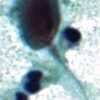

[   1  819  591  507  287  241  253  283  377  498  527  546 1023 1148
 1215 1684]


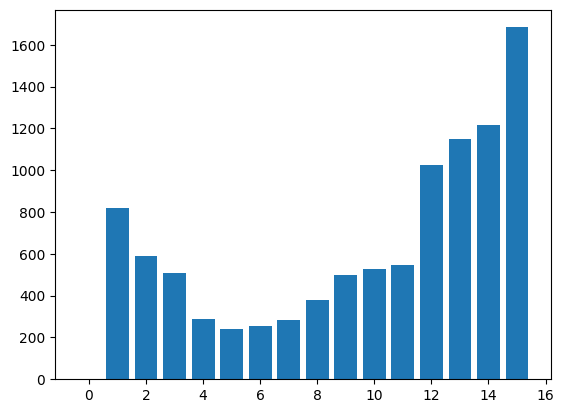

In [21]:
img = Image.open('classes/HSIL/7653.png')
display(img)

histogram = generate_grayscale_histogram(img)
print(histogram)

plt.bar(range(16), histogram)
plt.show()

[[0.000e+00 2.900e+01 1.100e+01 0.000e+00 0.000e+00 2.000e+00 0.000e+00
  2.040e+02]
 [0.000e+00 3.000e+00 1.600e+01 8.000e+00 2.000e+00 0.000e+00 0.000e+00
  1.800e+01]
 [0.000e+00 3.000e+00 9.000e+00 6.000e+00 3.000e+00 0.000e+00 1.000e+00
  7.400e+01]
 [0.000e+00 5.000e+00 8.000e+00 8.000e+00 7.000e+00 2.000e+00 5.000e+00
  4.500e+01]
 [0.000e+00 1.000e+00 4.000e+00 7.000e+00 5.000e+00 0.000e+00 1.000e+00
  4.300e+01]
 [0.000e+00 4.000e+00 9.000e+00 5.000e+00 4.000e+00 5.000e+00 9.000e+00
  1.280e+02]
 [0.000e+00 3.000e+00 4.000e+00 1.100e+01 1.900e+01 2.500e+01 6.600e+01
  2.140e+02]
 [0.000e+00 8.000e+00 3.400e+01 7.100e+01 2.060e+02 4.520e+02 7.940e+02
  1.059e+03]
 [0.000e+00 4.100e+01 2.340e+02 2.560e+02 3.020e+02 5.730e+02 9.830e+02
  1.384e+03]
 [9.000e+00 1.760e+02 2.460e+02 1.110e+02 8.600e+01 2.900e+01 5.800e+01
  4.350e+02]
 [2.800e+01 3.150e+02 3.000e+01 3.000e+00 2.000e+00 0.000e+00 2.000e+00
  8.800e+01]
 [2.000e+00 1.000e+02 0.000e+00 0.000e+00 0.000e+00 1.000e+00 1.0

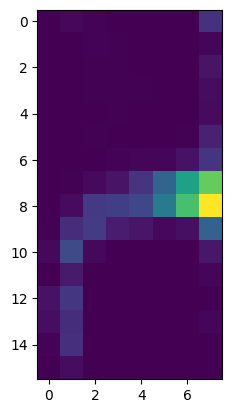

In [22]:
histogram_hsv = generate_hsv_histogram(img)
print(histogram_hsv)
plt.imshow(histogram_hsv, interpolation='nearest')
plt.show()

In [150]:
#q_img = quantize_image(img)
#
#haralick_features = compute_haralick_features(q_img)
#print("COM MAHOMES: ")
#print("Haralick Features:")
#print(f"Mean Haralick Features: {haralick_features}")
#
#glcm = compute_glcm(q_img)
#haralick_features = compute_haralick_features_naMao(glcm)
#print("NA MAO DAQUELE NAIPAO: ")
#print("Haralick Features:")
#print(f"Contrast: {haralick_features['contrast']}")
#print(f"Homogeneity: {haralick_features['homogeneity']}")
#print(f"Entropy: {haralick_features['entropy']}")
#
#
#cooccurrence_matrices = compute_cooccurrence_matrices(q_img)
#
#descriptors = compute_haralick_descriptors(cooccurrence_matrices)
#print(descriptors)

#get_haralick_pedrao(img)

In [151]:
#classes = data['bethesda_system'].unique()
#images, labels = load_data(classes)

In [23]:
features = []
labels = []

for index, row in data.iterrows():
    img_path = os.path.join(CLASSES_PATH, row['bethesda_system'], f"{row['cell_id']}.png")

    image = cv2.imread(img_path)

    if image is not None:
        haralick_features = compute_haralick_features(image)
        features.append(haralick_features)
        labels.append(row['bethesda_system'])

# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

#### Binary SVM Classifier

In [24]:
binary_labels = np.array([1 if label == 'Negative_for_intraepithelial_lesion' else 0 for label in labels])

X_train, X_test, y_train, y_test = train_test_split(features, binary_labels, test_size=0.2, stratify=binary_labels, random_state=49)

In [174]:
svm_classifier = SVC(kernel='linear', random_state=49)
svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred, zero_division=0, target_names=['Negativo', 'Positivo']))

print("Binary SVM Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

              precision    recall  f1-score   support

    Negativo       0.70      0.05      0.10       268
    Positivo       0.77      0.99      0.87       849

    accuracy                           0.77      1117
   macro avg       0.73      0.52      0.48      1117
weighted avg       0.75      0.77      0.68      1117

Binary SVM Accuracy: 0.7672336615935542
Confusion Matrix:
 [[ 14 254]
 [  6 843]]


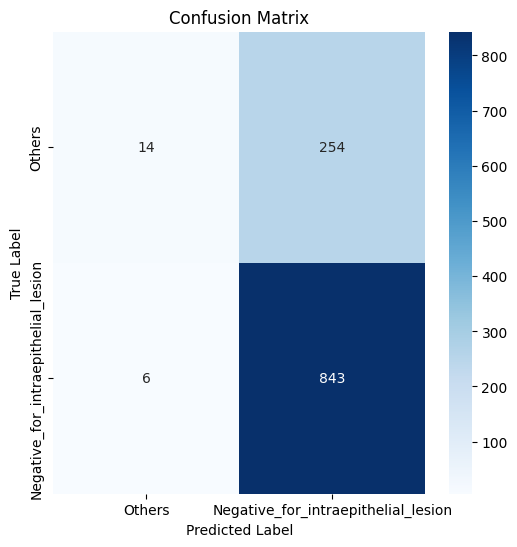

In [172]:
plot_confusion_matrix(conf_matrix, classes=['Others', 'Negative_for_intraepithelial_lesion'])

#### Multiclass SVM Classifier

In [25]:
X_train, X_test, y_train, y_test = train_test_split(features, binary_labels, test_size=0.2, stratify=labels, random_state=49)

In [26]:
# Multi-class classification: 6 classes
multi_svm = SVC(kernel='linear')
multi_svm.fit(X_train, y_train)

# Predictions and evaluation
multi_predictions = multi_svm.predict(X_test)
multi_accuracy = accuracy_score(y_test, multi_predictions)
multi_conf_matrix = confusion_matrix(y_test, multi_predictions)

print("Multi-Class SVM Accuracy:", multi_accuracy)
print("Multi-Class SVM Confusion Matrix:\n", multi_conf_matrix)

Multi-Class SVM Accuracy: 0.7779767233661593
Multi-Class SVM Confusion Matrix:
 [[ 45 223]
 [ 25 824]]


#### Binary EfficientNet

In [103]:
df = data.copy()

df['bethesda_system'] = df['bethesda_system'].replace('Negative for intraepithelial lesion', 'Negative_for_intraepithelial_lesion')
df['image_path'] = df.apply(lambda row: os.path.join(CLASSES_PATH, row['bethesda_system'], f"{row['cell_id']}.png"), axis=1)
df['binary_class'] = df['bethesda_system'].apply(lambda x: 'Negative' if x == 'Negative_for_intraepithelial_lesion' else 'Positive')

train_df, test_df = train_test_split(df, test_size=0.2, stratify=binary_labels, random_state=49)

In [81]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=90, zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',  # Assuming the path to the cropped image is in the 'image_path' column
    y_col='binary_class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',  # Assuming the path to the cropped image is in the 'image_path' column
    y_col='binary_class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Load the EfficientNetB0 model with pre-trained ImageNet weights
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.n // test_generator.batch_size,
    epochs=10
)



Found 4464 validated image filenames belonging to 2 classes.
Found 1117 validated image filenames belonging to 2 classes.
Epoch 1/10


c:\Users\Felipe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


139/139 ━━━━━━━━━━━━━━━━━━━━ 2137s 15s/step - accuracy: 0.7357 - loss: 0.5562 - val_accuracy: 0.7601 - val_loss: 7.2355
Epoch 2/10
  1/139 ━━━━━━━━━━━━━━━━━━━━ 11:47 5s/step - accuracy: 0.7188 - loss: 0.5159

c:\Users\Felipe\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7188 - loss: 0.5159 - val_accuracy: 0.7586 - val_loss: 22.0178
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2677s 19s/step - accuracy: 0.8336 - loss: 0.4055 - val_accuracy: 0.7583 - val_loss: 1.7808
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7812 - loss: 0.3894 - val_accuracy: 0.8276 - val_loss: 1.3278
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 782s 6s/step - accuracy: 0.8397 - loss: 0.3873 - val_accuracy: 0.2381 - val_loss: 0.7822
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9062 - loss: 0.2655 - val_accuracy: 0.3103 - val_loss: 0.7378
Epoch 7/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 782s 6s/step - accuracy: 0.8500 - loss: 0.3551 - val_accuracy: 0.7574 - val_loss: 0.5883
Epoch 8/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8750 - loss: 0.3739 - val_accuracy: 0.7586 - val_loss: 0.6058
Epoch 9/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 765s 5s/step - accuracy: 0.8605 - loss: 0.3392 - val_accuracy: 0.7491

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [84]:
model.save('efficientnet_binary_classifier.keras')

#### Multiclass EfficientNet

##### Data Preparation for Multi-Class Classification

In [30]:
df = data.copy()

df['bethesda_system'] = df['bethesda_system'].replace('Negative for intraepithelial lesion', 'Negative_for_intraepithelial_lesion')
df['image_path'] = df.apply(lambda row: os.path.join(CLASSES_PATH, row['bethesda_system'], f"{row['cell_id']}.png"), axis=1)

df['image_path'] = df['image_path'].astype(str)
df['bethesda_system'] = df['bethesda_system'].astype(str)

In [31]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=49, stratify=df['bethesda_system'])

In [32]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True, rotation_range=90, zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',  # Updated to use the full path
    y_col='bethesda_system',
    target_size=(224, 224),  # Change to (100, 100) if using original image size
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',  # Updated to use the full path
    y_col='bethesda_system',
    target_size=(224, 224),  # Change to (100, 100) if using original image size
    batch_size=32,
    class_mode='categorical'
)

Found 4464 validated image filenames belonging to 6 classes.
Found 1117 validated image filenames belonging to 6 classes.


##### Build the EfficientNet Model for Multi-Class Classification

In [1]:
# Get the number of classes from the training generator
num_classes = len(train_generator.class_indices)

# Load the EfficientNetB0 model, excluding the top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pool the features globally
x = Dropout(0.5)(x)  # Add dropout for regularization
x = Dense(128, activation='relu')(x)  # Dense layer with ReLU activation
x = Dropout(0.5)(x)  # Another dropout layer for regularization
predictions = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax activation for multi-class classification

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Debug: Summary of the model
#model.summary()


NameError: name 'train_generator' is not defined

In [37]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Number of epochs
epochs = 10

# Fit the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=[early_stopping]
)


Epoch 1/10


c:\Users\Felipe\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


140/140 ━━━━━━━━━━━━━━━━━━━━ 1618s 11s/step - accuracy: 0.7115 - loss: 0.9805 - val_accuracy: 0.7601 - val_loss: 1.1023
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1140s 8s/step - accuracy: 0.7779 - loss: 0.7356 - val_accuracy: 0.7126 - val_loss: 1.4642
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2356s 17s/step - accuracy: 0.7747 - loss: 0.7264 - val_accuracy: 0.7628 - val_loss: 10.4007
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 745s 5s/step - accuracy: 0.7914 - loss: 0.6136 - val_accuracy: 0.7601 - val_loss: 1.7673
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 743s 5s/step - accuracy: 0.8116 - loss: 0.5965 - val_accuracy: 0.7556 - val_loss: 1.2688
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 739s 5s/step - accuracy: 0.7992 - loss: 0.5950 - val_accuracy: 0.7663 - val_loss: 0.9463
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 743s 5s/step - accuracy: 0.8141 - loss: 0.5743 - val_accuracy: 0.7762 - val_loss: 0.7116
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1976s 14s/step - accuracy: 0.8048 - loss: 0.5528 - val_accurac

In [38]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

35/35 ━━━━━━━━━━━━━━━━━━━━ 28s 790ms/step - accuracy: 0.7951 - loss: 0.6338
Test accuracy: 79.59%


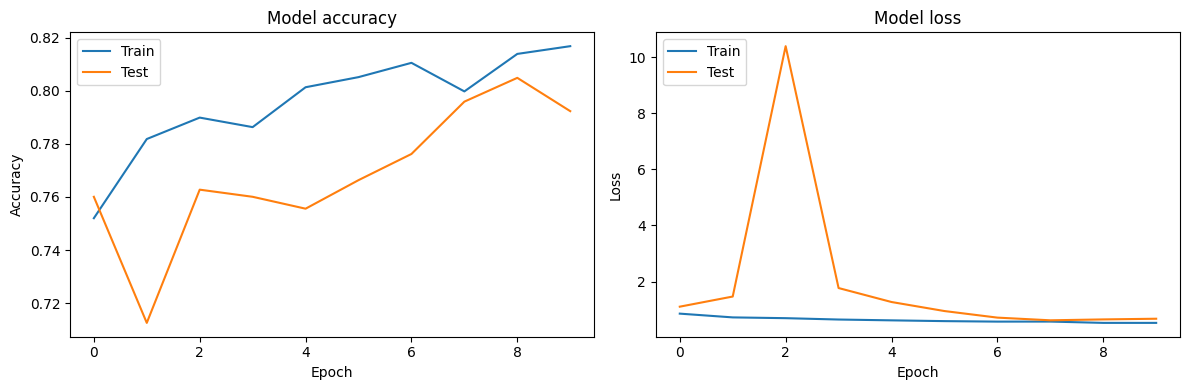

In [39]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [40]:
model.save('efficientnet_multiclass_classifier.keras')